In [124]:
from main import get_stock_data, add_fin_ratios_and_commodities
from fin_ratios import add_risk_measures, range_80

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

abca = get_stock_data('RMS.PA', lookback = '5y')
abca = add_fin_ratios_and_commodities(abca)
abca = add_risk_measures(abca)
abca.tail()

B:\Anaconda\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Open,High,Low,Close,Volume,Returns,Log Returns,Gold Close,WTI Oil Close,5Y TY ^FVX,CAC 40,CAC Returns,Sharpe 252,Sortino 252,Treynor 252,Beta 252,Sharpe 126,Sortino 126,Treynor 126,Beta 126,Sharpe 52,Sortino 52,Treynor 52,Beta 52,Sharpe 26,Sortino 26,Treynor 26,Beta 26,Var 252,CVar 252,Var 126,CVar 126,Var 52,CVar 52
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-11-30,1493.5,1559.0,1487.5,1542.5,358835,0.039420,0.038663,1746.000000,80.550003,3.832,6738.549805,0.010433,0.109635,0.188588,0.002091,1.197666,2.170771,4.163898,0.035520,1.256724,3.245436,6.447134,0.050341,1.387670,4.138232,13.641567,0.045308,1.821795,-0.038219,-0.045197,-0.025326,-0.036907,-0.025326,-0.039704
2022-12-01,1552.0,1553.5,1526.0,1532.5,73330,-0.006483,-0.006504,1801.099976,81.220001,3.680,6753.970215,0.002288,0.091738,0.158038,0.001750,1.197341,2.205304,4.206306,0.036133,1.253568,3.117602,6.280057,0.046848,1.435745,3.637100,12.291058,0.039993,1.824025,-0.038219,-0.045197,-0.025326,-0.036907,-0.025326,-0.039704
2022-12-02,1528.0,1543.0,1504.5,1520.5,70510,-0.007830,-0.007861,1795.900024,79.980003,3.666,6742.250000,-0.001735,0.087454,0.150781,0.001668,1.197817,2.305485,4.382659,0.037733,1.248720,2.719662,5.544856,0.040854,1.431788,3.972125,13.784273,0.043553,1.801043,-0.038219,-0.045197,-0.025326,-0.036907,-0.025326,-0.039704
2022-12-05,1525.0,1530.0,1505.5,1509.5,44512,-0.007234,-0.007261,1767.400024,76.930000,3.793,6696.959961,-0.006717,0.106773,0.183594,0.002037,1.196869,2.418009,4.584184,0.038923,1.262487,3.523836,9.603880,0.052860,1.348921,4.385932,16.252932,0.047076,1.804010,-0.038219,-0.045197,-0.025326,-0.036907,-0.024672,-0.027771
2022-12-06,1501.5,1517.0,1500.5,1513.0,29960,0.002319,0.002316,1784.900024,75.400002,3.764,6669.569824,-0.004090,0.043414,0.074469,0.000828,1.194418,2.738950,5.373246,0.043870,1.244492,4.137378,12.565255,0.060725,1.337757,4.724366,16.744749,0.051613,1.758009,-0.038219,-0.045197,-0.025307,-0.034296,-0.022975,-0.024999


In [125]:
range_80(abca, 'Sharpe 252')

(-0.18822388931381875, 1.8697546048857723)

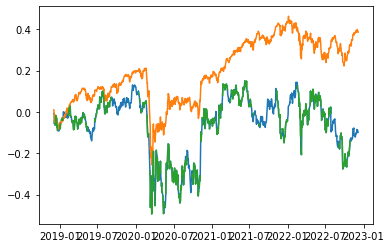

In [11]:
sharpe_sup_1 = abca.iloc[252:].cumsum()[abca['Beta 26'].iloc[252:]>1]['Returns'].resample('1d').first()
plt.plot(abca['Returns'].iloc[252:].cumsum())
plt.plot(abca['CAC Returns'].iloc[252:].cumsum())
plt.plot(sharpe_sup_1.resample('1d').first())

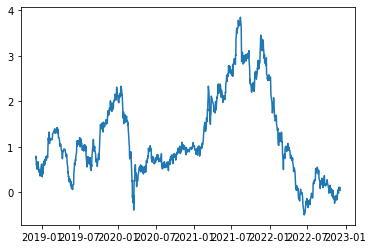

In [118]:
plt.plot(abca['Sharpe 252'].iloc[252:])

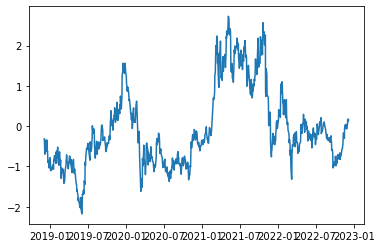

In [17]:
plt.plot(abca['Sortino 252'].iloc[252:])

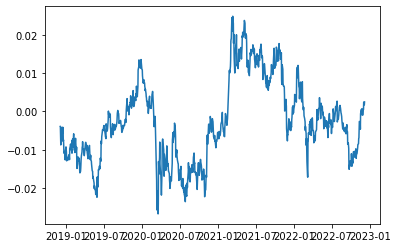

In [18]:
plt.plot(abca['Treynor 252'].iloc[252:])

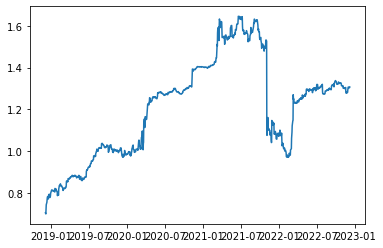

In [19]:
plt.plot(abca['Beta 252'].iloc[252:])

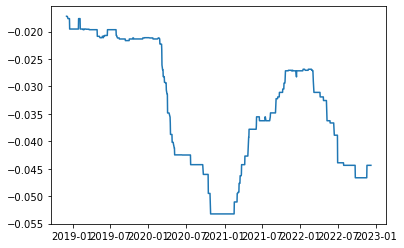

In [20]:
plt.plot(abca['Var 252'].iloc[252:])

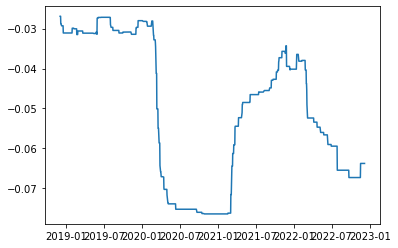

In [21]:
plt.plot(abca['CVar 252'].iloc[252:])

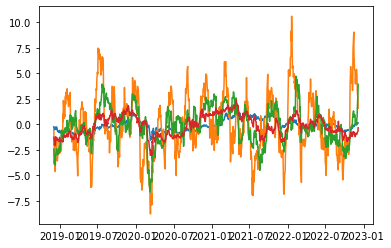

In [22]:
plt.plot(abca['Sharpe 252'].iloc[252:])
plt.plot(abca['Sharpe 26'].iloc[252:])
plt.plot(abca['Sharpe 52'].iloc[252:])
plt.plot(abca['Sharpe 126'].iloc[252:])

In [8]:
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy.signal import argrelextrema

def find_extrema(df):
    df = df.reset_index().iloc[:,1:]
    close_df = df['Close']
    #  Use Kernel Regression to create a fitted curve
    bandwidth = [1]
    kernel_regression = KernelReg([close_df.values], [close_df.index.to_numpy()], var_type='c', bw=bandwidth)
    regression_result = kernel_regression.fit([close_df.index])
    # Get smoothed close prices
    smoothed_close_df = pd.Series(data=regression_result[0], index=close_df.index)
    #  Calculate local mins and max for smoothed extrema
    smoothed_local_max = argrelextrema(smoothed_close_df.values, np.greater, order=12)[0]
    smoothed_local_min = argrelextrema(smoothed_close_df.values, np.less, order=12)[0]
    smoothed_local_max_min = np.sort(np.concatenate([smoothed_local_max, smoothed_local_min]))
    smoothed_extrema_df = smoothed_close_df.loc[smoothed_local_max_min]
    #  Calculate local mins and max for close prices
    local_max = argrelextrema(close_df.values, np.greater, order=12)[0]
    local_min = argrelextrema(close_df.values, np.less, order=12)[0]
    local_max_min = np.sort(np.concatenate([local_max, local_min]))
    close_extrema_df = close_df.loc[local_max_min]
    df['extrema'] = close_extrema_df
    df['smoothed_close'] = smoothed_close_df
    df['smoothed_extrema'] = smoothed_extrema_df
    return df

find_extrema(abca)

In [ ]:
tester ratio avec garxch et ewma
print les tickers des clusters

In [ ]:
It may be necessary to transform moving averages, such as by creating a moving average crossover column, in order to make them understandable by the algorithm. Moving averages are a common technical analysis tool that can help to smooth out short-term fluctuations in stock prices and identify longer-term trends. However, the raw moving average data may not be easily understood by the algorithm, as it is not directly related to the stock's performance. By creating additional columns that capture the relationship between different moving averages, such as a moving average crossover, the algorithm can more easily understand the data and make more informed predictions and decisions. This can help to improve the algorithm's overall performance.

In [ ]:
trier actions en fonction distribution sharpe beta 90% et garder les données en tant qu'indicateurs

In [ ]:
identifier les stocks les plus performants avec ratio par cluster => extraire les outliers PERFORMANTS

In [ ]:
pas faire la selection en fonction du sharpe ratio, ou plutot voir sharpe ratio anormaux et filtrer 

In [67]:
import urllib.request
import zipfile
import pandas as pd
#ratios mensuels
url = 'http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Europe_5_Factors_CSV.zip'

#read data from url
factors = pd.read_csv(url, skiprows=3).astype(str)
factors.rename(columns = {factors.columns[0] : 'date'},inplace=True)

#remove spacing problem
for col in factors.columns : 
    factors[col] = factors[col].apply(lambda x : x.strip())

#drop annual info at the end of file and rescale
annual_factors_index_cut = factors[factors['date'] == 'Annual Factors: January-December'].index[0]
factors.drop(factors.index[annual_factors_index_cut:], inplace=True)
factors['date'] = pd.to_datetime(factors['date'], format = '%Y%m') + pd.offsets.MonthEnd()
factors.iloc[:,1:] = factors.iloc[:,1:].astype(float)
factors.iloc[:,1:] = factors.iloc[:,1:]/100
factors = factors[factors['date'] > "2018-01-30"]

#append monthly return from stock
montly_returns = abca.Close.resample('M').last().pct_change().dropna()
montly_returns.name = "Month_Rtn"
factors = factors.merge(montly_returns,on='date').dropna()
factors.index = pd.to_datetime(factors['date'])
factors.drop(columns=['date'], inplace=True)
factors.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF,Month_Rtn
date,,,,,,,
2022-06-30,-0.1032,-0.0103,-0.0246,0.0172,0.0021,0.0006,-0.029046
2022-07-31,0.0526,0.0017,-0.0601,0.0335,-0.0393,0.0008,0.011519
2022-08-31,-0.0668,-0.0050,0.0541,-0.0321,0.0217,0.0019,0.004286
2022-09-30,-0.0984,-0.0351,0.0125,-0.0020,0.0275,0.0019,-0.089616
2022-10-31,0.0666,-0.0067,0.0244,0.0117,0.0013,0.0023,0.037500


In [97]:
import urllib.request
import zipfile
import pandas as pd
#ratios mensuels
url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Europe_5_Factors_Daily_CSV.zip'

#read data from url
factors = pd.read_csv(url, skiprows=3).astype(str)
factors.rename(columns = {factors.columns[0] : 'date'},inplace=True)

#remove spacing problem
for col in factors.columns : 
    factors[col] = factors[col].apply(lambda x : x.strip())
factors['date'] = pd.to_datetime(factors['date'], format = '%Y%m%d') + pd.offsets.MonthEnd()
factors.iloc[:,1:] = factors.iloc[:,1:].astype(float)/100
factors = factors[factors['date'] > "2010-01-30"]

monthly_returns = abca.Close.pct_change()
monthly_returns.name = "Month_Rtn"

factors = factors.merge(montly_returns,on='date').dropna()
factors.index = pd.to_datetime(factors['date'])
factors.drop(columns=['date'], inplace=True)
factors.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF,Close
date,,,,,,,
2022-10-31,0.0256,0.0021,-0.0191,0.0080,-0.0103,0.0001,-0.001527
2022-10-31,0.0171,0.0040,-0.0052,0.0012,-0.0027,0.0001,-0.001527
2022-10-31,-0.0111,0.0015,0.0153,-0.0061,0.0060,0.0001,-0.001527
2022-10-31,-0.0002,-0.0023,-0.0019,0.0000,0.0030,0.0001,-0.001527
2022-11-30,-0.0061,-0.0007,0.0045,-0.0042,0.0008,0.0001,0.006015


In [104]:
X = factors.iloc[:,:-2]
X = sm.add_constant(X)

Y = factors.iloc[:,-1]
Y.index = X.index

#regression => classical least squares method
model = sm.OLS(Y, X)
model_results = model.fit()
print(model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.601
Date:                Tue, 06 Dec 2022   Prob (F-statistic):             0.0748
Time:                        15:41:32   Log-Likelihood:                 2904.4
No. Observations:                 910   AIC:                            -5803.
Df Residuals:                     907   BIC:                            -5788.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.371      0.1

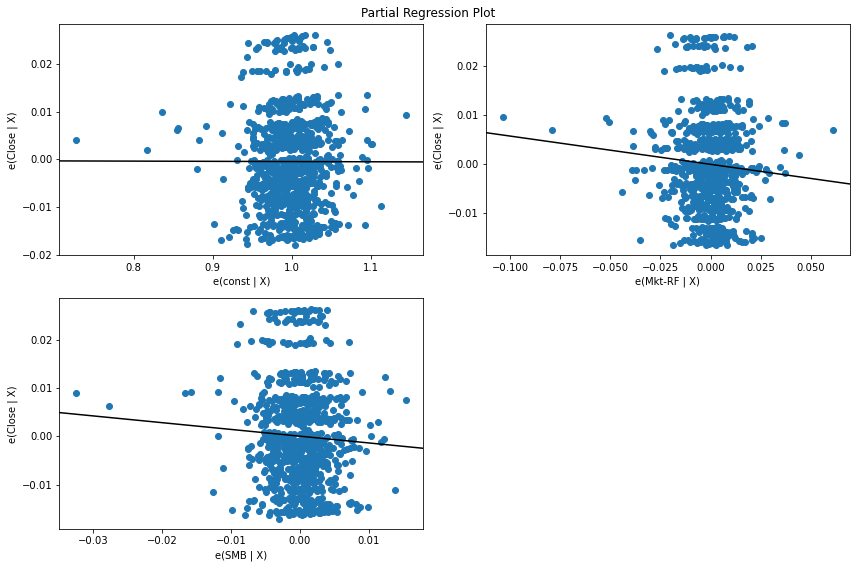

In [105]:
fig = sm.graphics.plot_partregress_grid(model_results, fig = plt.figure(figsize=(12,8)))
plt.show()

In [ ]:
si rentabilité du marché > rentabilité prédite ==> sur évaluation
si inférieure, opportunité
https://github.com/fischlerben/Algorithmic-Trading-Project/blob/main/Algorithmic_Trading.ipynb